# Size of seaweeds
---------------
Construction of a "seaweed" like in [Alternative solutions to diluted p-spin models and XORSAT problems](https://arxiv.org/pdf/cond-mat/0207140.pdf), appendix A.

**Claim**: starting from a solution to a parity-check system, any variable in the floppy part of the graph can be flipped and another valid solution can be found by adjusting a finite number of additional variables. Such variables are the ones touched by the seaweed at the end of the algorithm described in the paper.

**Here**: At fixed rate  $R$ , for increasing graph size  $n$ :

+ for a set of  $G$  randomly picked graphs, grow a seaweed starting from each of the variables, and compute its Hamming weight. Average over $Q$ starting points. Then further average over the  $G$  graph instances.
+ Observe how the estimated expected hamming weight changes with  $n$ .

In [1]:
using Plots, ProgressMeter
include("../code/headers.jl")

mpldefault (generic function with 1 method)

In [39]:
# Increasing graph sizes
n_vals = Int.(floor.(10 .^(LinRange(2,3.6,8))))
# Fixed rate
R = 0.3
# Number of graphs to average over
G = 100
# Number of factors removed during b-reduction
b = 1
# Number of seaweeds to be grown
Q = 100
# Initalize vector to store seaweed sizes
sz = [zeros(G) for n in n_vals]
# Keep track of the number of leaves exposed
nleaves = [zeros(Int, G) for n in n_vals];

In [40]:
function avg_seaweed_hw!(G::Int, n::Int, R::Float64, b::Int, j::Int, nseaweeds::Int, sz, nleaves)
    @assert nseaweeds <= n
    @showprogress "Averaging over graphs... " for g in 1:G
        # Build random factor graph
        m = floor(Int, n*(1-R))
        fg = ldpc_graph(2, n, m)
        # Remove a factor to create leaves
        breduction!(fg, b)
        nleaves[j][g] = nvarleaves(fg)
        # Find depths and core
        _,depths = lr(fg)
        isincore = (depths .== 0)
        noncore_vars = (1:fg.n)[.!isincore]
        # Starting from nseaweeds nodes picked at random
        seeds = noncore_vars[randperm(length(noncore_vars))[1:nseaweeds]]
        for i in seeds
            # Grow a seaweed
            sw = seaweed(fg, i, depths, isincore)
            # Measure the size
            sz[j][g] += hw(sw)
        end
        # Take the average seaweed size
        sz[j][g] /= length(seeds)
    end
    return nothing
end

avg_seaweed_hw! (generic function with 1 method)

In [41]:
for (j,n) in enumerate(n_vals)
    runtime = @timed begin
        println("n = $n")
        avg_seaweed_hw!(G, n, R, b, j, Q, sz, nleaves)
    end
end

n = 100


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:01


n = 169


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:05


n = 286


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:10


n = 484


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:22


n = 820


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:59


n = 1389


Averaging over graphs... 100%|██████████████████████████| Time: 0:02:40


n = 2351


Averaging over graphs... 100%|██████████████████████████| Time: 0:09:36


n = 3981


Averaging over graphs... 100%|██████████████████████████| Time: 0:25:13


Plot the seaweed Hamming weight versus $n$

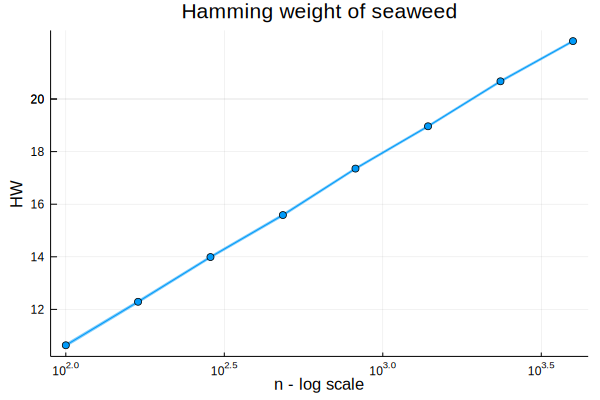

In [42]:
avg_sizes = [mean(sz[j]) for j in eachindex(n_vals)]
sd_sizes = [std(sz[j])/sqrt(G) for j in eachindex(n_vals)]
Plots.plot(n_vals, avg_sizes, ribbon=sd_sizes, label="", markershape=:circle, xscale=:log10)
xlabel!("n - log scale")
ylabel!("HW")
title!("Hamming weight of seaweed")

Looks like it is scaling as $\log n$ 

## Now b-reduction scales with n
I'm performing $b$-reduction to expose leaves. In the previous, we had a fixed $b=1$ for all values of $n$.

In the following, the number $b$ of removed factors scales linearly with $n$:
$$b=\frac{n}{100}.$$

It is to be expected that, as $b$ increases, the number of leaves in the graph increases linearly with it (checked at the end)

In [43]:
b = ceil.(Int, n_vals ./ 100)
# Initalize vector to store seaweed sizes
sz_new = [zeros(G, n) for n in n_vals]
# Keep track of the number of leaves exposed
nleaves_new = [zeros(Int, G) for n in n_vals];

In [ ]:
for (j,n) in enumerate(n_vals)
    runtime = @timed begin
        println("n = $n")
        avg_seaweed_hw!(G, n, R, b[j], j, Q, sz_new, nleaves_new)
    end
end

n = 100


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:02


n = 169


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:06


n = 286


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:11


n = 484


Averaging over graphs... 100%|██████████████████████████| Time: 0:00:24


n = 820


Averaging over graphs... 100%|██████████████████████████| Time: 0:01:02


n = 1389


Averaging over graphs...  66%|█████████████████▏        |  ETA: 0:00:55

Plot the seaweed Hamming weight versus $n$

In [ ]:
avg_sizes = [mean(sz_new[j]) for j in eachindex(n_vals)]
sd_sizes = [std(sz_new[j])/sqrt(G) for j in eachindex(n_vals)]
Plots.plot(n_vals, avg_sizes, ribbon=sd_sizes, label="", markershape=:circle, xscale=:log10)
xlabel!("n - log scale")
ylabel!("HW")
title!("Hamming weight of seaweed, b scaling with n")

It looks like it is indeed going slower than $\log n$!